<a href="https://colab.research.google.com/github/heesukjang/Income_Prediction/blob/main/EXPERIMENT_3_CNN_Transfer_Learning_W207_Fall2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#W207 Applied Machine Learning
**Fall 2022**<br>
Heesuk Jang

# CNN With Transfer Learning - With Concatenated Pre-Trained Models

## Machine Learning Pipepline

  1) EDA and Image Visualization<br>
> On the original entire dataset<br>
> On the 1200 sample dataset: randomly sample from training/test/validation = 800/ 200/ 200 (67%/ 17%/ 17%%)

  2) Image Augmentations<br>
> Adjust brightness<br>
> Adjust contrast<br>
> Horizontal flip<br>
> Vertical flip<br>
> Random rotate<br>
> Rotate 90 degrees counter clockwise<br>
> Rotate 90 degrees clockwise<br>
> Histogram equalized image


3) Image Normalization to [0, 1]<br>
4) Employ Transfer Learning Models<br>
> VGG16<br>
> Xception<br>
> ResNet152<br>

 5) Define a Custom CNN with Xception, ResNet152, and VGG16<br>
 6) Define a Custom CNN with ResNet152, and VGG16<br>

 7) Predict and Evaluate the Model (True Labels VS. Predicted Labels)<br>
> Accuracy: Training/Test/Validation<br>
> Confusion Matrix<br>
> Recall, Precision, F1 Score<br>
> ROC-AUC Score and Area Under the ROC Curve<br>
> Zero One Loss<br>
> Number of Trainable Parameters<br>







In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import joblib
import glob
import random
from itertools import product
import gc
import subprocess
import shutil
import copy
import statistics as st
from scipy import stats

from imutils import rotate as rotate
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from skimage.color import gray2rgb
import skimage.io as skio
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Concatenate

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, cohen_kappa_score, zero_one_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Multiply
# from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import PReLU, ReLU, LeakyReLU
from keras.layers.core import Activation
from keras.layers.convolutional import SeparableConv1D
from keras.layers.convolutional import SeparableConv2D 
from keras.layers.core import Activation
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from tensorflow.keras.models import Sequential

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import *
from keras.applications.resnet import ResNet152
from tensorflow.keras.applications import ResNet152V2
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input
from keras.applications import MobileNetV2
from keras.applications.xception import Xception
from keras.applications.inception_v3 import *


from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, save_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=DeprecationWarning)

# Required to read the data from Kaggle
from google.colab import drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 135 kB 28.1 MB/s 
     |████████████████████████████████| 1.6 MB 65.4 MB/s 


# Unzip the zip with 1200 samples
- Training/Test/Validate = 800/200/200

In [3]:
!unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip                  

Archive:  gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip
   creating: Dataset/
   creating: Dataset/Validate/
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/Test/
   creating: Dataset/Train/
  inflating: Dataset/Validate/.DS_Store  
  inflating: __MACOSX/Dataset/Validate/._.DS_Store  
   creating: Dataset/Validate/0/
   creating: Dataset/Validate/1/
  inflating: Dataset/Test/.DS_Store  
  inflating: __MACOSX/Dataset/Test/._.DS_Store  
   creating: Dataset/Test/0/
   creating: Dataset/Test/1/
  inflating: Dataset/Train/.DS_Store  
  inflating: __MACOSX/Dataset/Train/._.DS_Store  
   creating: Dataset/Train/0/
   creating: Dataset/Train/1/
  inflating: Dataset/Validate/0/12867_idx5_x651_y1801_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._12867_idx5_x651_y1801_class0.png  
  inflating: Dataset/Validate/0/16165_idx5_x3001_y1551_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._16165_idx5_x3001_y1551_class0.png  
  inflating

# Check on the count of image files

In [4]:
# Delete a full folder including all its files and subfolders if exists
!rm -rf processed_images/   

# Check the dataset and count of files
!ls -ltr Dataset  
!ls -ltr Dataset/Train/0|wc -l
!ls -ltr Dataset/Train/1|wc -l

!ls -ltr Dataset/Test/0|wc -l
!ls -ltr Dataset/Test/1|wc -l

!ls -ltr Dataset/Validate/0|wc -l
!ls -ltr Dataset/Validate/1|wc -l                             

total 12
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Test
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Train
drwxr-xr-x 4 root root 4096 Oct  4 01:10 Validate
401
401
101
101
101
101


# Remove unnecessary files from the folder that contains the original images





In [5]:
val_image_directory = '/content/Dataset/Validate'
train_image_directory = '/content/Dataset/Train'
test_image_directory = '/content/Dataset/Test'
directory_path = '/content/Dataset'

In [6]:
def preprocess(data_dir):
  ''' 
  Remove .DS_Store files from each sub-folders
  '''

  images_path_1 = [data_dir + '/' +  dir + '/' for dir in os.listdir(data_dir) if dir != '.DS_Store'][1]      
  images_path_0 = [data_dir + '/' +  dir + '/' for dir in os.listdir(data_dir) if dir != '.DS_Store'][0]
  images_list_1 = [images_path_1 + file for file in list(os.walk(images_path_1))[0][2] if file[0] != '.']
  images_list_0 = [images_path_0 + file for file in list(os.walk(images_path_0))[0][2] if file[0] != '.']
  return images_list_1, images_list_0

In [7]:
train_1_images_list, train_0_images_list = preprocess(train_image_directory)
test_1_images_list, test_0_images_list = preprocess(test_image_directory)
val_1_images_list, val_0_images_list = preprocess(val_image_directory)

# Re-check the count of PNG files

In [8]:
print('Count of the entire samples: ', len(train_1_images_list + train_0_images_list + test_1_images_list + test_0_images_list + val_1_images_list + val_0_images_list))
print(f'Length of train 1: {len(train_1_images_list)} \nLength of train 0: {len(train_0_images_list)} \nLength of test 1: {len(test_1_images_list)} \nLength of test 0: {len(test_0_images_list)} \nLength of val 1: {len(val_1_images_list)} \nLength of val 0: {len(val_0_images_list)}')

Count of the entire samples:  1200
Length of train 1: 400 
Length of train 0: 400 
Length of test 1: 100 
Length of test 0: 100 
Length of val 1: 100 
Length of val 0: 100


## Display the first 6 images for each class
: IDC Malignant (1) vs. IDC Benign (0)


In [9]:
IMG_SIZE = 50

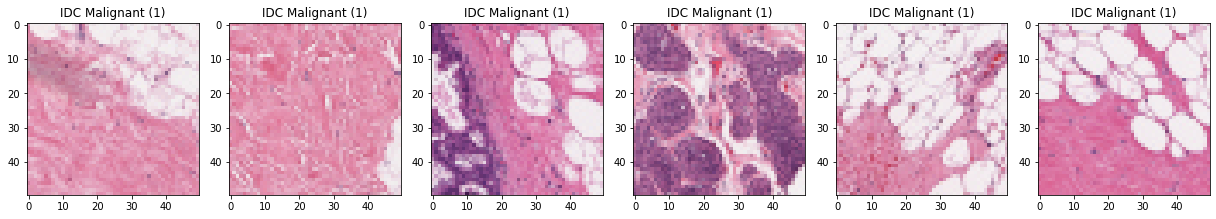

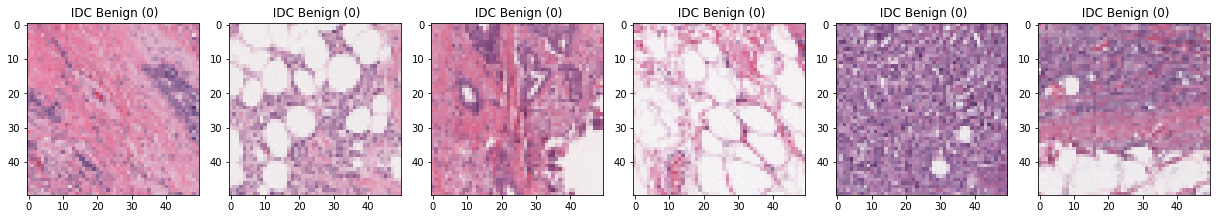

In [10]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    # ax.set_xticks([])       # remove xticks passing an empty array
    # ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(train_1_images_list, 'IDC Malignant (1)')
display_images(train_0_images_list, ' IDC Benign (0)')

# Check the image dimension in different color scale
- RGB with 3-channels
- Grayscale with 1-channel

Grayscale image shape:  (50, 50, 1)
RGB image shape:  (50, 50, 3)


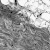

In [11]:
# Grayscale
test_img = load_img(train_1_images_list[0], color_mode ="grayscale")
test_img_arry = img_to_array(test_img)/255                                 # normalize
print('Grayscale image shape: ',test_img_arry.shape)

# RGB
test_img1 = load_img(train_1_images_list[0])
test_img1_arry = img_to_array(test_img1)
print('RGB image shape: ',test_img1_arry.shape)

array_to_img(test_img_arry)

# Create new directory paths to store processed images


In [15]:
# Define the folder paths where the processed images will be stored
dest_directory_path = '/content/processed_images'
dest_train_1_image_path = '/content/processed_images/train/1/'
dest_train_0_image_path = '/content/processed_images/train/0/'
dest_val_1_image_path = '/content/processed_images/val/1/'
dest_val_0_image_path = '/content/processed_images/val/0/'
dest_test_1_image_path = '/content/processed_images/test/1/'
dest_test_0_image_path = '/content/processed_images/test/0/'

lst_target_folder_path = [dest_train_1_image_path, dest_train_0_image_path,
                 dest_val_1_image_path, dest_val_0_image_path,
                 dest_test_1_image_path, dest_test_0_image_path
                ]

root_dir = 'processed_images'

os.makedirs(f'{root_dir}', exist_ok = True)
for dir in ['train', 'val', 'test']:
    for sub_dir in ['1', '0']:
        os.makedirs(f'{root_dir}/{dir}/{sub_dir}', exist_ok=True)              

# Display images with each effect of augmentation technique


  Original:50x50(RGB)



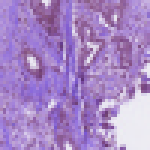


 Not normalized-Original:50x50(Gray)



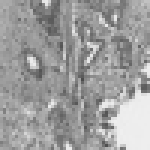


Normalized-gray



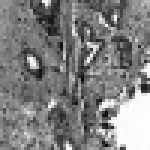


 Brightness:0.1,0.3



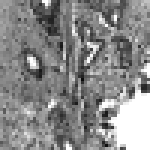


    Contrast:1,3



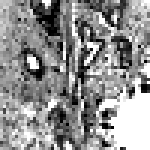


  Horizontal Flip



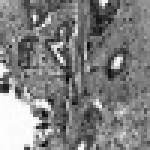


   Vertical Flip



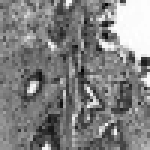


    RandomRotate



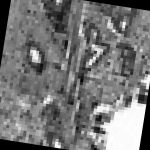


    Rotate 90:CCW



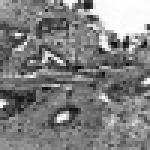


     Rotate 90:CW



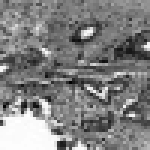


 RandomShift:LeftDown



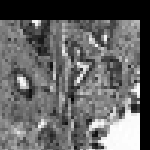


 RandomShift:RightUp



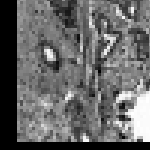

In [16]:
# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

from google.colab.patches import cv2_imshow
target_size=(150,150)

# original: 50x50 rgb 
org_img = load_img(train_0_images_list[2], color_mode ="rgb", target_size=target_size)
org_img_arry = img_to_array(org_img)
print("  Original:50x50(RGB)");print()
cv2_imshow(org_img_arry)

# original: 50x50 grayscale 
test_img = load_img(train_0_images_list[2], color_mode ="grayscale", target_size=target_size)
test_img_arry = img_to_array(test_img)
print();print(" Not normalized-Original:50x50(Gray)");print()
cv2_imshow(test_img_arry)

#  normalized gray scale
norm_test_img_arry = cv2.normalize(test_img_arry, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
print();print('Normalized-gray');print()
cv2_imshow(norm_test_img_arry)
# print('norm1-gray:\n', norm_test_img_arry)

# brightness
bright_img_gs = tf.image.adjust_brightness(norm_test_img_arry, delta=10)
bright_img_gs = img_to_array(bright_img_gs)
print();print(" Brightness:0.1,0.3");print()
cv2_imshow(bright_img_gs)

# contrast
contrast_img_gs = tf.image.adjust_contrast(test_img_arry, contrast_factor=3)
contrast_img_gs = img_to_array(contrast_img_gs)
print();print("    Contrast:1,3");print()
cv2_imshow(contrast_img_gs)

# horizontal flip
hflip_img_gs = cv2.flip(norm_test_img_arry, 1)
print();print("  Horizontal Flip");print()
cv2_imshow(hflip_img_gs)

# vertical flip
vflip_img_gs = cv2.flip(norm_test_img_arry, 0)
print();print("   Vertical Flip");print()
cv2_imshow(vflip_img_gs)

# random rotate 
angle = int(random.uniform(-90, 90))
hr, wr = norm_test_img_arry.shape[:2]
M = cv2.getRotationMatrix2D((int(wr/2), int(hr/2)), angle, 1)
rotated_img_gs = cv2.warpAffine(norm_test_img_arry, M, (wr, hr))
rotated_img_gs = img_to_array(rotated_img_gs)
print();print("    RandomRotate");print()
cv2_imshow(rotated_img_gs)

# rotate 90 degree ccw
out=cv2.transpose(norm_test_img_arry)
out=cv2.flip(out,flipCode=0)
rotated_img_gs = img_to_array(out)
print();print("    Rotate 90:CCW");print()
cv2_imshow(out)

# rotate 90 degree cw
out=cv2.transpose(norm_test_img_arry)
out=cv2.flip(out,flipCode=1)
rotated_img_gs = img_to_array(out)/255        # normalize it after augment the image
# print('rotated_img_gs',rotated_img_gs)
print();print("     Rotate 90:CW");print()
cv2_imshow(out)

# shift the image 5 pixels to the left and 10 pixels down
M = np.float32([[1, 0, -10], [0, 1, 20]])
shifted_ld_gs = cv2.warpAffine(norm_test_img_arry, M, (norm_test_img_arry.shape[1], norm_test_img_arry.shape[0]))
print();print(" RandomShift:LeftDown");print()
cv2_imshow(shifted_ld_gs)

# shift the image 5 pixels to the right and 10 pixels up
M = np.float32([[1, 0, 17], [0, 1, -8]])
shifted_ru_gs = cv2.warpAffine(norm_test_img_arry, M, (norm_test_img_arry.shape[1], norm_test_img_arry.shape[0]))
print();print(" RandomShift:RightUp");print()
cv2_imshow(shifted_ru_gs)

# Filter Out Odd Images
- Exclude images that are not **50 by 50**
- Exclude images with no **.png** extension

In [12]:
odd_images = []
def extract_odd_images(file_list, IMG_SIZE = 50):
    for file_name in file_list:
        test_img = load_img(file_name, color_mode ="grayscale")
        test_img_arry = img_to_array(test_img)
        if test_img_arry.shape[0] != IMG_SIZE or test_img_arry.shape[1] != IMG_SIZE:
            odd_images.append(file_name)

In [13]:
extract_odd_images(train_1_images_list + train_0_images_list + test_1_images_list + test_0_images_list + val_1_images_list + val_0_images_list)

In [14]:
print(f'Number of Bad Images: ', len(odd_images),'\n')
odd_images

Number of Bad Images:  7 



['/content/Dataset/Train/0/9347_idx5_x2101_y801_class0.png',
 '/content/Dataset/Train/0/12954_idx5_x1651_y2951_class0.png',
 '/content/Dataset/Train/0/13106_idx5_x1_y2951_class0.png',
 '/content/Dataset/Test/0/13404_idx5_x1101_y2901_class0.png',
 '/content/Dataset/Validate/0/12931_idx5_x1901_y2151_class0.png',
 '/content/Dataset/Validate/0/13694_idx5_x1551_y2801_class0.png',
 '/content/Dataset/Validate/0/9320_idx5_x801_y2951_class0.png']

# Display the 7 bad images
- 3 images from training set
- 3 images from validation set
- 1 image from test set

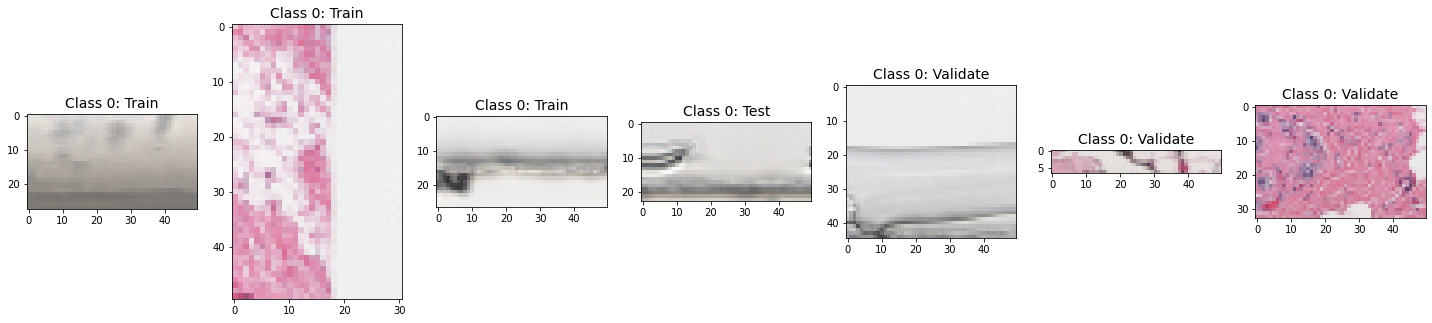

In [ ]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass[idx])
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass[idx].split('/')[3]
    img = io.imread(subclass[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print();display_images(odd_images)

# Image augmentation on training dataset

Images are already normalized in **ImageDataGenerator by rescaling 1.0/255** thus we DO NOT NEED to normalize images in this **augmentation_on_grayscale_grayscale()** function.

In [23]:
def augmentation_on_grayscale(file_list, dest_dir, ind, brightness_delta=0.3, contrast_factor=3):
  lst_train_1_gs, lst_train_0_gs = [], []
  lst_val_1_gs, lst_val_0_gs = [], []
  lst_test_1_gs, lst_test_0_gs = [], []

  file_extension = '.png'
  for image_file in file_list:
      if image_file[0] == '.' or image_file in odd_images:                                        # if image_file = .DS_Store or an odd image then ignore
          continue
      img_gs = load_img(image_file, color_mode = "grayscale")                                     # convert images from colorscale to grayscale
      img_array_gs = img_to_array(img_gs)                                                         # convert grayscale images to array
      
      file_name = image_file.split("/")[-1]                                                       # extract only filenames from the full file path
      save_img(dest_dir + file_name.split(".")[0] + '_gs' + file_extension, img_array_gs)
      if ind == 1:
          # insert raw training images in gray scale
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)

          # adjust brightness
          bright_img_gs = tf.image.adjust_brightness(img_array_gs, delta=brightness_delta)
          img_array_bright_gs = img_to_array(bright_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension, img_array_bright_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension)
          
          # adjust contrast
          contrast_img_gs = tf.image.adjust_contrast(img_array_gs, contrast_factor=contrast_factor)
          img_array_contrast_gs = img_to_array(contrast_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension, img_array_contrast_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension)

          # horizontal flip
          hflip_img_gs = cv2.flip(img_array_gs, 1)
          img_array_hflip_gs = img_to_array(hflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension, img_array_hflip_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension)

          # vertical flip
          vflip_img_gs = cv2.flip(img_array_gs, 0)
          img_array_vflip_gs = img_to_array(vflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension, img_array_vflip_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension)

          # random rotate
          angle = int(random.uniform(-90, 90))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension)
          '''
          angle = int(random.uniform(-279, 270))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension)
          
          img_90rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_90_CLOCKWISE)
          img_array_90rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_90rot_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          
          img_180rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_180_CLOCKWISE)
          img_array_180rot_gs = img_to_array(img_180rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension, img_array_180rot_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension)

          img_270rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_270_CLOCKWISE)
          img_array_270rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_270rot_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          '''
          #  histogram equalized image
          img_gs = cv2.imread(image_file, 0)
          img_array_enhanced_gs = cv2.equalizeHist(img_gs)
          img_array_enhanced_gs = img_to_array(img_array_enhanced_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_enhance_gs' + file_extension, img_array_enhanced_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_enhanced_gs' + file_extension)

          # transpose and rotate 90 degrees counter clockwise (flip around x-axis)
          img_ccw90rot_gs = cv2.transpose(img_array_gs)
          img_ccw90rot_gs = cv2.flip(img_ccw90rot_gs, flipCode = 0)
          rotatedccw90_img_gs = img_to_array(img_ccw90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension, rotatedccw90_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension)
          #print("e")

          # transpose and rotate 90 degrees (flip around y-axis)
          img_90rot_gs = cv2.transpose(img_array_gs)
          img_90rot_gs = cv2.flip(img_90rot_gs, flipCode = 1)
          rotated90_img_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, rotated90_img_gs)
          lst_train_1_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          #print("f")

      elif ind == 2:
          # insert raw training images in gray scale
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)

          # adjust brightness
          bright_img_gs = tf.image.adjust_brightness(img_array_gs, delta=brightness_delta)
          img_array_bright_gs = img_to_array(bright_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension, img_array_bright_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_bright_gs' + file_extension)
          
          # adjust contrast
          contrast_img_gs = tf.image.adjust_contrast(img_array_gs, contrast_factor=contrast_factor)
          img_array_contrast_gs = img_to_array(contrast_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension, img_array_contrast_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_contrast_gs' + file_extension)

          # horizontal flip
          hflip_img_gs = cv2.flip(img_array_gs, 1)
          img_array_hflip_gs = img_to_array(hflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension, img_array_hflip_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_hflip_gs' + file_extension)

          # vertical flip
          vflip_img_gs = cv2.flip(img_array_gs, 0)
          img_array_vflip_gs = img_to_array(vflip_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension, img_array_vflip_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_vflip_gs' + file_extension)

          # rotate 90 degree
          angle = int(random.uniform(-90, 90))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rotated_gs' + file_extension)
          '''
          angle = int(random.uniform(-279, 270))
          h, w = img_array_gs.shape[:2]
          M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
          rotated_img_gs = cv2.warpAffine(img_array_gs, M, (w, h))
          img_array_rotated_gs = img_to_array(rotated_img_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension, img_array_rotated_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_270rotated_gs' + file_extension)
          
          img_90rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_90_CLOCKWISE)
          img_array_90rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_90rot_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          
          img_180rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_180_CLOCKWISE)
          img_array_180rot_gs = img_to_array(img_180rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension, img_array_180rot_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_180rot_gs' + file_extension)

          img_270rot_gs = cv2.rotate(img_gs, cv2.cv2.ROTATE_270_CLOCKWISE)
          img_array_270rot_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, img_array_270rot_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)
          '''
          #  histogram equalized image
          img_gs = cv2.imread(image_file, 0)
          img_array_enhanced_gs = cv2.equalizeHist(img_gs)
          img_array_enhanced_gs = img_to_array(img_array_enhanced_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_enhance_gs' + file_extension, img_array_enhanced_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_enhanced_gs' + file_extension)

          # transpose and rotate 90 degrees counter clockwise (flip around x-axis)
          img_ccw90rot_gs = cv2.transpose(img_array_gs)
          img_ccw90rot_gs = cv2.flip(img_ccw90rot_gs, flipCode = 0)
          rotatedccw90_img_gs = img_to_array(img_ccw90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension, rotatedccw90_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_ccw90rot_gs' + file_extension)

          # transpose and rotate 90 degrees (flip around y-axis)
          img_90rot_gs = cv2.transpose(img_array_gs)
          img_90rot_gs = cv2.flip(img_90rot_gs, flipCode = 1)
          rotated90_img_gs = img_to_array(img_90rot_gs)
          save_img(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension, rotated90_img_gs)
          lst_train_0_gs.append(dest_dir + file_name.split(".")[0] + '_90rot_gs' + file_extension)

      elif ind == 3:
          lst_val_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif ind == 4:
          lst_val_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif ind == 5:
          lst_test_1_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
      elif ind == 6:
          lst_test_0_gs.append(dest_dir + file_name.split(".")[0] + '_gs' + file_extension)
              

# Store Processed Images to New Directory
- Convert color to gray scale
- Append augmented images

In [24]:
augmentation_on_grayscale(train_1_images_list, dest_train_1_image_path, 1, 0.3, 3)
augmentation_on_grayscale(train_0_images_list, dest_train_0_image_path, 2, 0.3, 3)
augmentation_on_grayscale(val_1_images_list, dest_val_1_image_path, 3, 0.3, 3)
augmentation_on_grayscale(val_0_images_list, dest_val_0_image_path, 4, 0.3, 3)
augmentation_on_grayscale(test_1_images_list, dest_test_1_image_path, 5, 0.3, 3)
augmentation_on_grayscale(test_0_images_list, dest_test_0_image_path, 6, 0.3, 3)

# Check the Number of Processed Images in Each Class of Training Dataset

In [25]:
!ls -ltra /content/processed_images/train/1/*.png|wc -l
!ls -ltra /content/processed_images/train/0/*.png|wc -l

3573
3600


# Define ImageDataGenerator 
- 1200 given raw images + augmented images<br>
- Normalize the pixels to the range of [0,1] using **rescale** in ImageDataGenerator

In [26]:
batch_size = 64
random_state = 1234
image_size = 50

def data_generator(image_size): 
  processed_images_train_path = '/content/processed_images/train'                       # contains augmented images with original images 
  processed_images_validation_path = '/content/processed_images/val'
  processed_images_test_path = '/content/processed_images/test'

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)          # Normalize image pixels to the range of [0,1]
  train_data_generator = datagen.flow_from_directory(processed_images_train_path,
                                                                      target_size = (image_size, image_size),
                                                                      class_mode = 'categorical',
                                                                      batch_size = batch_size,
                                                                      color_mode = 'rgb',
                                                                      shuffle = True,
                                                                      seed = random_state
                                                                      )
  val_data_generator = datagen.flow_from_directory(processed_images_validation_path,
                                                                  target_size = (image_size, image_size),
                                                                  class_mode = 'categorical',
                                                                  batch_size = batch_size,
                                                                  color_mode = 'rgb',
                                                                  shuffle = True,
                                                                  seed = random_state
                                                                  )
  test_data_generator = datagen.flow_from_directory(processed_images_test_path,
                                                                    target_size = (image_size, image_size),
                                                                    batch_size = batch_size,
                                                                    class_mode = 'categorical',
                                                                    color_mode = 'rgb',
                                                                    shuffle = False,
                                                                    seed = random_state
                                                                    )
  return train_data_generator, val_data_generator, test_data_generator

# Define Transfer Learning Models

In [ ]:
def build_transfer_learning_model(chosen_model):
    """
    Utilizes transfer learning of a given custom model.
    """
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    tf.keras.backend.clear_session()

    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    if chosen_model == 'VGG19':
        model_tl = VGG19(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'DenseNet201':
        model_tl = tf.keras.applications.densenet.DenseNet201(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'ResNet50':
        model_tl = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'ResNet152V2':
        model_tl = ResNet152V2(weights = 'imagenet', include_top = False, input_shape = input_shape)       
    elif chosen_model == 'VGG16':
        model_tl = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'EfficientNetB7':
        model_tl = tf.keras.applications.efficientnet.EfficientNetB7(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'MobileNetV2':
        model_tl = MobileNetV2(weights='imagenet',include_top = False, input_shape=input_shape)
    elif chosen_model == 'Xception':
        model_tl = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = input_shape)
    elif chosen_model == 'InceptionV3':
        model_tl = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = input_shape)
    return model_tl

# Define plot_model_accuracy_and_loss function

In [ ]:
def plot_model_accuracy_and_loss(history, chosen_model):
   """
   Plots model training and validation accuracy and loss.
   """
   tf.keras.backend.clear_session()

   hist = history.history
   x_arr = np.arange(len(hist['loss'])) + 1
        
   fig = plt.figure(figsize=(12, 4))
   ax = fig.add_subplot(1, 2, 1)
   ax.plot(x_arr, hist['loss'], '-o', label = 'Train Loss')
   ax.plot(x_arr, hist['val_loss'], '--<', label = 'Val Loss')
   ax.legend(fontsize=15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Loss', size = 15)

   ax = fig.add_subplot(1, 2, 2)
   ax.plot(x_arr, hist['accuracy'], '-o', label = 'Train Acc')
   ax.plot(x_arr, hist['val_accuracy'], '--<', label = 'Val Acc')
   ax.legend(fontsize = 15)
   ax.set_xlabel('Epoch', size = 15)
   ax.set_ylabel('Accuracy', size = 15)
   ax.set_ylim(0,1)
   plt.title(f"{chosen_model}")
   plt.show(block = False)

In [28]:
chosen_model = 'Resnet152_VGG16'
image_size = 75
lr=0.01
activation = 'leaky_relu'
optimizer='adam'

random_state=1234

# CNN with Xception, ResNet152, and VGG16

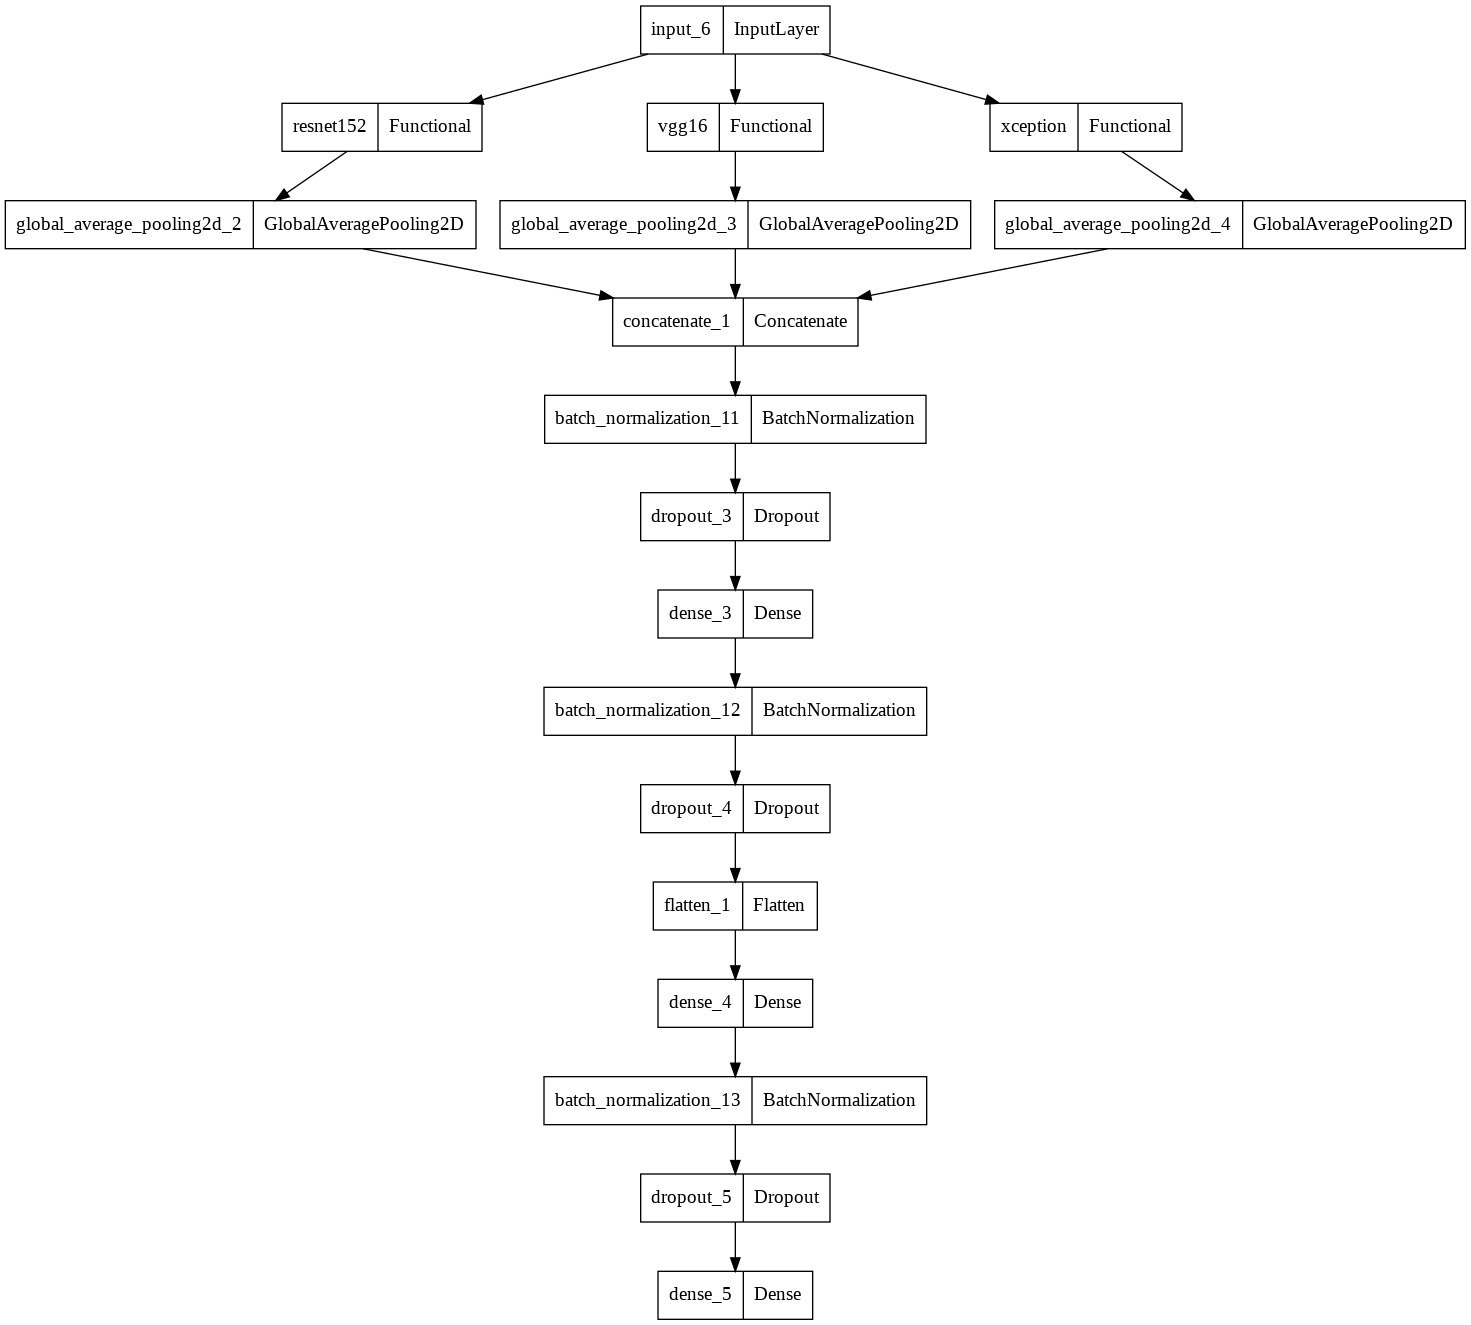

In [31]:
input_shape = (image_size, image_size, 3)
inputs = Input(input_shape)
xception = Xception(include_top=False, input_shape=input_shape)(inputs)
resnet = ResNet152(include_top=False, input_shape=input_shape)(inputs)
vgg16 = VGG16(include_top=False, input_shape=input_shape)(inputs)

xception.trainable = False
vgg16.trainable = False
resnet.trainable = False

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(resnet),
                                    GlobalAveragePooling2D()(vgg16),
                                    GlobalAveragePooling2D()(xception)
                                   ])

outputs = BatchNormalization()(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(512, activation='leaky_relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.2)(outputs)                                       
outputs = Flatten()(outputs)
outputs = Dense(256, activation='leaky_relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.2)(outputs) 
outputs = Dense(2, activation = 'softmax')(outputs)

model = Model(inputs, outputs)
    
tf.keras.utils.plot_model(model)

Found 7173 images belonging to 2 classes.
Found 197 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Epoch 1/20
113/113 [==============================] - 69s 321ms/step - loss: 0.7753 - accuracy: 0.6584 - val_loss: 4041.9082 - val_accuracy: 0.5076
Epoch 2/20
113/113 [==============================] - 32s 286ms/step - loss: 0.6453 - accuracy: 0.6944 - val_loss: 1.4484 - val_accuracy: 0.5076
Epoch 3/20
113/113 [==============================] - 33s 287ms/step - loss: 0.6147 - accuracy: 0.7123 - val_loss: 0.9173 - val_accuracy: 0.4924
Epoch 4/20
113/113 [==============================] - 28s 246ms/step - loss: 0.7186 - accuracy: 0.7142 - val_loss: 863414.0625 - val_accuracy: 0.5076
Epoch 5/20
113/113 [==============================] - 28s 249ms/step - loss: 0.6246 - accuracy: 0.7177 - val_loss: 25542.5234 - val_accuracy: 0.3959
Epoch 6/20
113/113 [==============================] - 28s 247ms/step - loss: 0.6051 - accuracy: 0.7192 - val_loss: 5.3145 - val_accuracy: 0

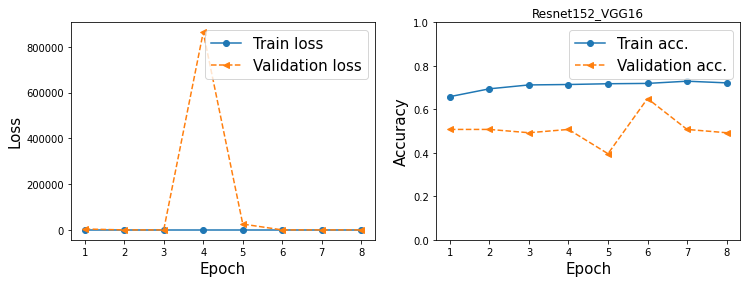

In [ ]:
# ==================== model.compile ====================================
from IPython.display import Image

tf.keras.utils.plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5', save_best_only=True)]
                                 
optimizer = Adam(learning_rate=lr)
model.compile(loss=CategoricalCrossentropy(),
              optimizer=opt,
              metrics=['accuracy'])

# =================== datagen.flow_from_directory =========================
batch_size = 64
epochs = 20

processed_images_train_path = '/content/processed_images/train'           # contains augmented images with original images (4782 = IDC(1): 2400 + IDC(1): 2382)
processed_images_validation_path = '/content/processed_images/val'
processed_images_test_path = '/content/processed_images/test'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)

train_data_generator = datagen.flow_from_directory(processed_images_train_path,
                                                                     target_size = (IMG_SIZE, IMG_SIZE),
                                                                     class_mode = 'categorical',
                                                                     batch_size = batch_size,
                                                                     color_mode = 'rgb',
                                                                     shuffle = True,
                                                                     seed = random_state
                                                                    )
val_data_generator = datagen.flow_from_directory(processed_images_validation_path,
                                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                                 class_mode = 'categorical',
                                                                 batch_size = batch_size,
                                                                 color_mode = 'rgb',
                                                                 shuffle = True,
                                                                 seed = random_state
                                                                )
test_data_generator = datagen.flow_from_directory(processed_images_test_path,
                                                                   target_size = (IMG_SIZE, IMG_SIZE),
                                                                   batch_size = batch_size,
                                                                   class_mode = 'categorical',
                                                                   color_mode = 'rgb',
                                                                   shuffle = False,
                                                                   seed = random_state
                                                                  )
# ============== model.fit ================================================
start_time = time.time()

history = model.fit(train_data_generator,
                      epochs = epochs,
                      batch_size = batch_size,                       # ADDIITION
                      shuffle=True,                                  # ADDIITION
                      steps_per_epoch = len(train_data_generator),
                      validation_data = val_data_generator,
                      validation_steps = len(val_data_generator),
                      callbacks=callbacks,                           # ADDIITION
                      verbose = 1)

# ============= Model save ================================================
print("Saving model...")
tf.keras.backend.clear_session()
# gc.collect()                                                      # UPDATED
model.save('breast_cancer_detection_' + chosen_model + '.h5')
print();print('Execution time %s minutes: ' % round(int(time.time() - start_time)/60, 2),'\n')

# ============= Plot loss and accuracy of model: train vs val ==========
# print(f"{chosen_model}")
plot_model_accuracy_and_loss(history = history, chosen_model = chosen_model)

# Train the Model

Found 7173 images belonging to 2 classes.
Found 197 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Epoch 1/20
113/113 [==============================] - 78s 389ms/step - loss: 0.7425 - accuracy: 0.6828 - val_loss: 38.4898 - val_accuracy: 0.5076
Epoch 2/20
113/113 [==============================] - 40s 352ms/step - loss: 0.5579 - accuracy: 0.7532 - val_loss: 0.6348 - val_accuracy: 0.6751
Epoch 3/20
113/113 [==============================] - 37s 330ms/step - loss: 0.4904 - accuracy: 0.7863 - val_loss: 302.4508 - val_accuracy: 0.5076
Epoch 4/20
113/113 [==============================] - 39s 349ms/step - loss: 0.4930 - accuracy: 0.7740 - val_loss: 0.5991 - val_accuracy: 0.7208
Epoch 5/20
113/113 [==============================] - 38s 334ms/step - loss: 0.4356 - accuracy: 0.8058 - val_loss: 0.7152 - val_accuracy: 0.6548
Epoch 6/20
113/113 [==============================] - 37s 330ms/step - loss: 0.3923 - accuracy: 0.8256 - val_loss: 0.6920 - val_accuracy: 0.6853
Epo

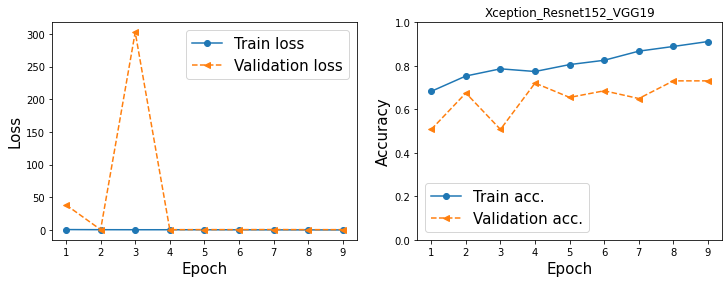

In [ ]:
# ==================== model.compile =====================================
from IPython.display import Image

tf.keras.utils.plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5', save_best_only=True)]
                                 
optimizer = Adam(learning_rate=lr)
model.compile(loss=CategoricalCrossentropy(),
              optimizer=opt,
              metrics=['accuracy'])

# =================== datagen.flow_from_directory =========================
batch_size = 64
epochs = 20

processed_images_train_path = '/content/processed_images/train'           # contains augmented images with original images (4782 = IDC(1): 2400 + IDC(1): 2382)
processed_images_validation_path = '/content/processed_images/val'
processed_images_test_path = '/content/processed_images/test'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)

train_data_generator = datagen.flow_from_directory(processed_images_train_path,
                                                                     target_size = (IMG_SIZE, IMG_SIZE),
                                                                     class_mode = 'categorical',
                                                                     batch_size = batch_size,
                                                                     color_mode = 'rgb',
                                                                     shuffle = True,
                                                                     seed = random_state
                                                                    )
val_data_generator = datagen.flow_from_directory(processed_images_validation_path,
                                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                                 class_mode = 'categorical',
                                                                 batch_size = batch_size,
                                                                 color_mode = 'rgb',
                                                                 shuffle = True,
                                                                 seed = random_state
                                                                )
test_data_generator = datagen.flow_from_directory(processed_images_test_path,
                                                                   target_size = (IMG_SIZE, IMG_SIZE),
                                                                   batch_size = batch_size,
                                                                   class_mode = 'categorical',
                                                                   color_mode = 'rgb',
                                                                   shuffle = False,
                                                                   seed = random_state
                                                                  )
# ============== model.fit ================================================
start_time = time.time()

history = model.fit(train_data_generator,
                      epochs = epochs,
                      batch_size = batch_size,                       
                      shuffle=True,                                  
                      steps_per_epoch = len(train_data_generator),
                      validation_data = val_data_generator,
                      validation_steps = len(val_data_generator),
                      callbacks=callbacks,                           
                      verbose = 1)

# ============= Model save ================================================
print("Saving model...")
tf.keras.backend.clear_session()
model.save('breast_cancer_detection_' + chosen_model + '.h5')
print();print('Execution time %s minutes: ' % round(int(time.time() - start_time)/60, 2),'\n')

# ============= Plot loss and accuracy of model: train vs val ==========
plot_model_accuracy_and_loss(history = history, chosen_model = chosen_model)

# Predict and evaluate the model performance

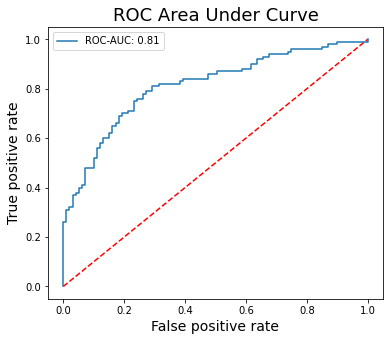

,TL Model,Test_Loss,Test_Acc,Train_Acc,Val_Acc,Num_Trainable_Params,Precision,Recall,F1_score,ROC-AUC,Cohen Kappa,Zero-One Loss,lr,activation,optimizer
0,Xception_Resnet152_VGG19,0.79,0.72,0.91,0.73,"101,553,258",0.73,0.72,0.71,0.81,0.44,0.28,0.01,leaky_relu,sgd


In [ ]:
batch_size = 64

# =========== model.evaluate ===============================================
# test_loss, test_accuracy, precision1, recall1, auc1 = model.evaluate(test_data_generator, verbose = 0)
test_loss, test_accuracy = model.evaluate(test_data_generator, verbose = 0)
training_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
# count_params = model.count_params()
count_trainable_params = count_params(model.trainable_weights)

# =========== model.predict (transform logits to probabilities) ===========
classes = ['IDC(0)','IDC(1)']

y_true = test_data_generator.classes
y_pred = model.predict(test_data_generator, steps = (test_data_generator.n // batch_size + 1), verbose = 0)
y_pred_argmax = np.argmax(y_pred, axis=1) 

# ========== Precision, recall, f1score ====================================
precision, recall, f1score, support = score(y_true, y_pred_argmax, average='macro')

# ========== cohen_kappa score, zero_one loss
cohen_kappa = round(cohen_kappa_score(y_true, y_pred_argmax), 2)
zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

# ========== Area under the ROC curve ======================================
roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
area_under_curve = round(metrics.auc(fpr, tpr), 2) 

plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'r--')  
plt.plot(fpr, tpr, label='ROC-AUC: {:.2f}'.format(area_under_curve))  
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC Area Under Curve', fontsize=18)
plt.legend(loc='best')
plt.show()

# ========== Performace metrics summary ===================================
perf_metrics = pd.DataFrame({'TL Model':chosen_model, 
                             'Test_Loss':round(test_loss,2), 
                             'Test_Acc':round(test_accuracy, 2), 
                             'Train_Acc':round(training_accuracy, 2), 
                             'Val_Acc':round(val_accuracy, 2), 
                             'Num_Trainable_Params':  f'{count_trainable_params:,}',
                             'Precision':round(precision, 2), 
                             'Recall':round(recall, 2), 
                             'F1_score': round(f1score, 2),
                             'ROC-AUC':round(area_under_curve, 2), 
                             'Cohen Kappa': cohen_kappa,
                             'Zero-One Loss': zo_loss,
                             'lr':lr,
                             'activation':activation,
                             'optimizer':optimizer}, index=[0])
perf_metrics

# CNN with ResNet152 and VGG16

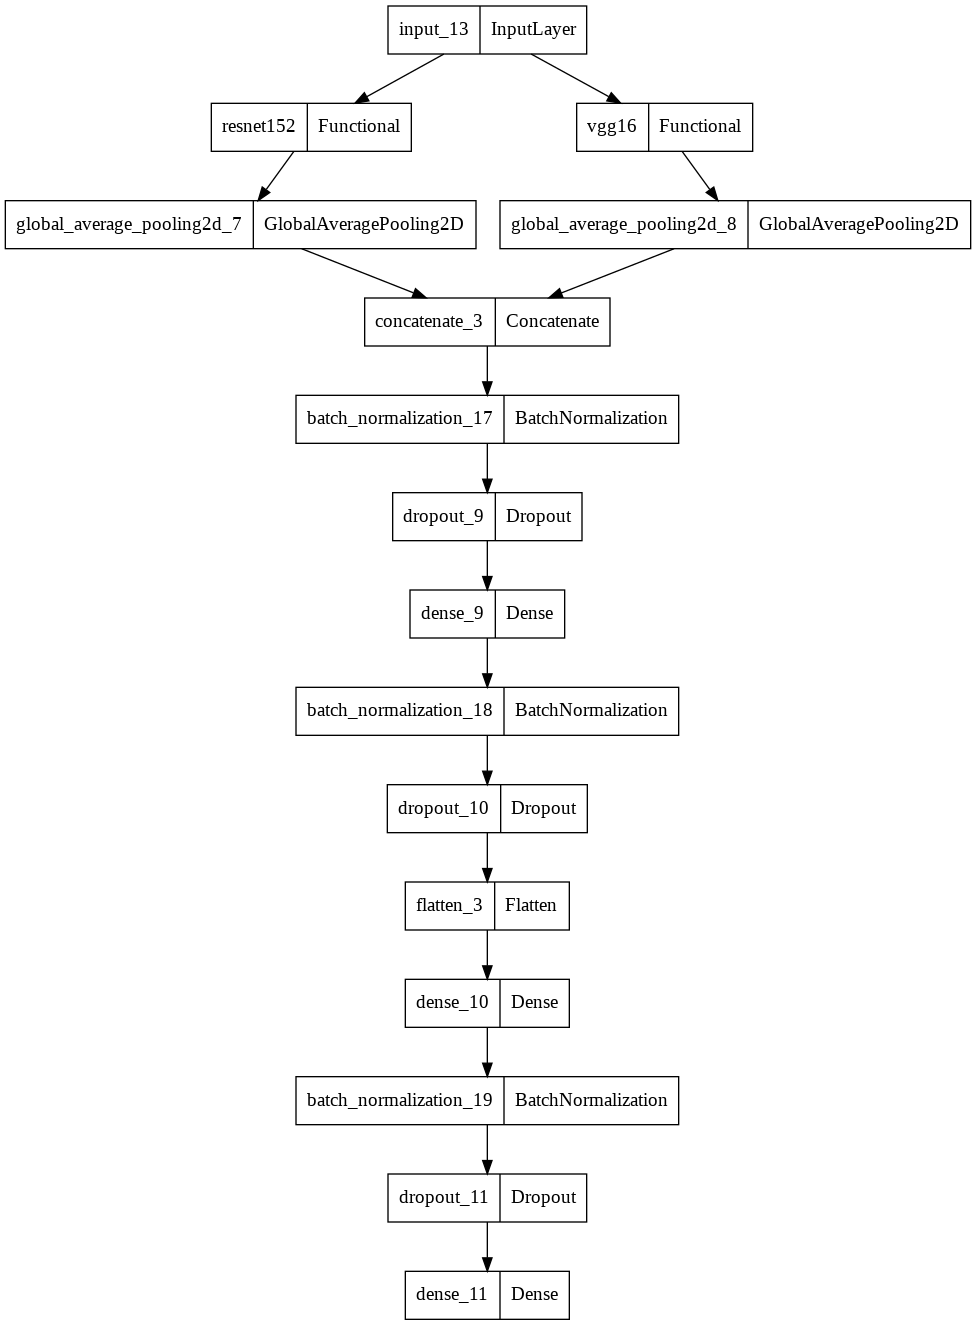

In [33]:
image_size=50
input_shape = (image_size, image_size, 3)
inputs = Input(input_shape)

resnet = ResNet152(include_top=False, input_shape=input_shape)(inputs)
vgg16 = VGG16(include_top=False, input_shape=input_shape)(inputs)

vgg16.trainable = False
resnet.trainable = False

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(resnet),
                                    GlobalAveragePooling2D()(vgg16)
                                   ])

outputs = BatchNormalization()(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(512, activation='leaky_relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.2)(outputs)                                       
outputs = Flatten()(outputs)
outputs = Dense(256, activation='leaky_relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.2)(outputs) 
outputs = Dense(2, activation = 'softmax')(outputs)

model = Model(inputs, outputs)
    
tf.keras.utils.plot_model(model)

# Predict and evaluate the model performance

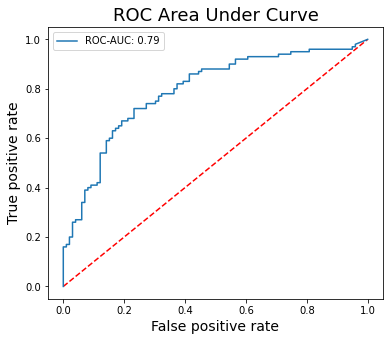

,TL Model,Test_Loss,Test_Acc,Train_Acc,Val_Acc,Num_Trainable_Params,Precision,Recall,F1_score,ROC-AUC,Cohen Kappa,Zero-One Loss,lr,activation,optimizer
0,Resnet152_VGG16,3.2,0.5,0.72,0.49,"74,383,938",0.25,0.5,0.33,0.79,0.0,0.5,0.01,leaky_relu,adam


In [ ]:
batch_size = 64

# =========== model.evaluate ===============================================
# test_loss, test_accuracy, precision1, recall1, auc1 = model.evaluate(test_data_generator, verbose = 0)
test_loss, test_accuracy = model.evaluate(test_data_generator, verbose = 0)
training_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
# count_params = model.count_params()
count_trainable_params = count_params(model.trainable_weights)

# =========== model.predict (transform logits to probabilities) ===========
classes = ['IDC(0)','IDC(1)']

y_true = test_data_generator.classes
y_pred = model.predict(test_data_generator, steps = (test_data_generator.n // batch_size + 1), verbose = 0)
y_pred_argmax = np.argmax(y_pred, axis=1) 

# ========== Precision, recall, f1score ====================================
precision, recall, f1score, support = score(y_true, y_pred_argmax, average='macro')

# ========== cohen_kappa score, zero_one loss
cohen_kappa = round(cohen_kappa_score(y_true, y_pred_argmax), 2)
zo_loss = round(zero_one_loss(y_true, y_pred_argmax), 2)

# ========== Area under the ROC curve ======================================
roc_log = roc_auc_score(y_true, y_pred[:,1], multi_class='ovr')   # for the roc curve, we need to use a vector of probabilities so just chose one column and all rows
fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
area_under_curve = round(metrics.auc(fpr, tpr), 2) 

plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'r--')  
plt.plot(fpr, tpr, label='ROC-AUC: {:.2f}'.format(area_under_curve))  
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC Area Under Curve', fontsize=18)
plt.legend(loc='best')
plt.show()

# ========== Performace metrics summary ===================================
perf_metrics = pd.DataFrame({'TL Model':chosen_model, 
                             'Test_Loss':round(test_loss,2), 
                             'Test_Acc':round(test_accuracy, 2), 
                             'Train_Acc':round(training_accuracy, 2), 
                             'Val_Acc':round(val_accuracy, 2), 
                             'Num_Trainable_Params':  f'{count_trainable_params:,}',
                             'Precision':round(precision, 2), 
                             'Recall':round(recall, 2), 
                             'F1_score': round(f1score, 2),
                             'ROC-AUC':round(area_under_curve, 2), 
                             'Cohen Kappa': cohen_kappa,
                             'Zero-One Loss': zo_loss,
                             'lr':lr,
                             'activation':activation,
                             'optimizer':optimizer}, index=[0])
perf_metrics